In [ ]:
# de_pyopencl_gpu.py
# Full Differential Evolution (GPU) using PyOpenCL.
# - Mutation + Crossover implemented on GPU
# - Fitness (Rastrigin) computed on GPU
# - Selection (replace if trial better) implemented on GPU
#
# Requirements:
#   pip install pyopencl numpy
# On AMD, ensure OpenCL drivers are installed and the AMD device is available.

import numpy as np
import pyopencl as cl
import time

# --------------------------
# Problem & DE hyperparams
# --------------------------
POP = 512        # population size (choose multiple of work-group sizes for best perf)
DIM = 30         # problem dimension
BOUNDS = (-5.12, 5.12)
F = 0.8          # mutation factor
CR = 0.9         # crossover probability
GENERATIONS = 1000

# --------------------------
# Select OpenCL device/context
# --------------------------
platforms = cl.get_platforms()

device = platforms[0].get_devices()
print(device)
ctx = cl.Context(devices=[device])
queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
print("Using device:", device.vendor, device.name)

# --------------------------
# OpenCL kernels
# --------------------------
kernel_source = r"""
// Standard helper
inline float rand_from_buf(__global const float *rands, uint i, uint d, uint D) {
    // rands is size N*D stored row-major: rands[i*D + d]
    return rands[i*D + d];
}

// Kernel 1: build trial vectors via DE/rand/1/bin
__kernel void build_trial(
    const uint N, const uint D,
    const float F,
    const float CR,
    __global const float *pop,        // size N*D
    __global const uint  *r1,         // size N
    __global const uint  *r2,         // size N
    __global const uint  *r3,         // size N
    __global const float *crossover_rands, // size N*D (uniform 0..1)
    __global float *trial             // output size N*D
) {
    const uint i = get_global_id(0); // individual
    const uint d = get_global_id(1); // dimension
    if (i >= N || d >= D) return;

    const uint idx = i*D + d;

    // pick jrand: ensure at least one dimension is taken
    // We'll compute jrand on host and pass as rands with sentinel? Simpler: host also provides jrand array.
    // For simplicity we compute a jrand here from crossover_rands[i*D] scaled to D (deterministic per-run).
    // But because host passes a fresh random matrix each generation, this is fine.
    uint jrand = (uint)(cross_over_seed(i) % D); // placeholder won't compile
    // ----
    // We'll avoid computing jrand in the kernel since OpenCL C has no easy call here.
    // Instead we rely on the host ensuring that for each i there's at least one dimension where crossover_rands < 0.
    // To make this safe: host will set crossover_rands[i*D + jrand] = -1.0 so it's always chosen.
    // So we only check the crossover value here.

    float crv = crossover_rands[idx];
    // value from donors:
    float v1 = pop[ (uint)r1[i]*D + d ];
    float v2 = pop[ (uint)r2[i]*D + d ];
    float v3 = pop[ (uint)r3[i]*D + d ];

    float mutant = v1 + F * (v2 - v3);
    float base = pop[ i*D + d ];

    // binomial crossover
    if (crv < CR) {
        trial[idx] = mutant;
    } else {
        // If host set crossover_rands for jrand to -1.0, this branch won't be taken for that dimension.
        trial[idx] = base;
    }
}

// Kernel 2: fitness function (Rastrigin)
__kernel void fitness_rastrigin(
    const uint N, const uint D,
    const float A,
    __global const float *pop,   // N*D
    __global float *fitness      // N
) {
    const uint i = get_global_id(0);
    if (i >= N) return;

    float s = 0.0f;
    for (uint d = 0; d < D; ++d) {
        float x = pop[i*D + d];
        s += (x * x - A * cos(6.28318530718f * x)); // 2*pi ~ 6.28318530718
    }
    fitness[i] = A * (float)D + s;
}

// Kernel 3: selection (replace population elements if trial is better)
__kernel void select_and_replace(
    const uint N, const uint D,
    __global float *pop,           // in/out N*D
    __global float *pop_fitness,   // in/out N
    __global const float *trial,   // N*D
    __global const float *trial_fitness
) {
    const uint i = get_global_id(0);
    if (i >= N) return;
    if (trial_fitness[i] <= pop_fitness[i]) {
        // copy trial vector into population
        for (uint d = 0; d < D; ++d) {
            pop[i*D + d] = trial[i*D + d];
        }
        pop_fitness[i] = trial_fitness[i];
    }
}
"""

# NOTE: The above code had a placeholder for jrand logic which is awkward inside kernel.
# To keep kernel simple and robust we implement the following host-side guarantees:
# - host provides crossover_rands array (N*D) with uniform [0,1) randoms
# - for each individual i host sets crossover_rands[i*D + jrand] = -1.0
#   so that in kernel the branch (crv < CR) will be true for that dimension, ensuring at least one dimension from mutant.
# We'll therefore build a modified version of the kernel string without the jrand placeholder.

kernel_source = r"""
__kernel void build_trial(
    const uint N, const uint D,
    const float F,
    const float CR,
    __global const float *pop,        // size N*D
    __global const uint  *r1,         // size N
    __global const uint  *r2,         // size N
    __global const uint  *r3,         // size N
    __global const float *crossover_rands, // size N*D (uniform 0..1, with one element set to -1.0 per individual)
    __global float *trial             // output size N*D
) {
    const uint i = get_global_id(0); // individual
    const uint d = get_global_id(1); // dimension
    if (i >= N || d >= D) return;

    const uint D_u = D;
    const uint idx = i*D_u + d;

    float crv = crossover_rands[idx];

    // donor values
    uint r1i = r1[i];
    uint r2i = r2[i];
    uint r3i = r3[i];

    float v1 = pop[ r1i * D_u + d ];
    float v2 = pop[ r2i * D_u + d ];
    float v3 = pop[ r3i * D_u + d ];

    float mutant = v1 + F * (v2 - v3);
    float base = pop[ i*D_u + d ];

    // binomial crossover
    if (crv < CR) {
        trial[idx] = mutant;
    } else {
        trial[idx] = base;
    }
}

__kernel void fitness_rastrigin(
    const uint N, const uint D,
    const float A,
    __global const float *pop,   // N*D
    __global float *fitness      // N
) {
    const uint i = get_global_id(0);
    if (i >= N) return;
    float s = 0.0f;
    for (uint d = 0; d < D; ++d) {
        float x = pop[i*D + d];
        s += (x * x - A * cos(6.28318530718f * x));
    }
    fitness[i] = A * (float)D + s;
}

__kernel void select_and_replace(
    const uint N, const uint D,
    __global float *pop,           // in/out N*D
    __global float *pop_fitness,   // in/out N
    __global const float *trial,   // N*D
    __global const float *trial_fitness
) {
    const uint i = get_global_id(0);
    if (i >= N) return;
    if (trial_fitness[i] <= pop_fitness[i]) {
        for (uint d = 0; d < D; ++d) {
            pop[i*D + d] = trial[i*D + d];
        }
        pop_fitness[i] = trial_fitness[i];
    }
}
"""

# --------------------------
# Build program
# --------------------------
prg = cl.Program(ctx, kernel_source).build()

# --------------------------
# Initialize population (host)
# --------------------------
low, high = BOUNDS
rng = np.random.default_rng(seed=12345)
pop_host = rng.uniform(low, high, size=(POP, DIM)).astype(np.float32)
# flatten for OpenCL row-major indexing
pop_flat = pop_host.ravel().astype(np.float32)

# allocate buffers
mf = cl.mem_flags
pop_buf = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=pop_flat)
trial_buf = cl.Buffer(ctx, mf.READ_WRITE, pop_flat.nbytes)

# random index arrays for donors (r1,r2,r3)
r1_host = np.empty(POP, dtype=np.uint32)
r2_host = np.empty(POP, dtype=np.uint32)
r3_host = np.empty(POP, dtype=np.uint32)
r1_buf = cl.Buffer(ctx, mf.READ_ONLY, r1_host.nbytes)
r2_buf = cl.Buffer(ctx, mf.READ_ONLY, r2_host.nbytes)
r3_buf = cl.Buffer(ctx, mf.READ_ONLY, r3_host.nbytes)

# crossover randoms: N*D floats, we will set one jrand per individual to -1.0
crossover_host = np.empty((POP, DIM), dtype=np.float32)
crossover_buf = cl.Buffer(ctx, mf.READ_ONLY, crossover_host.nbytes)

# fitness buffers
pop_fitness_host = np.empty(POP, dtype=np.float32)
trial_fitness_host = np.empty(POP, dtype=np.float32)
pop_fitness_buf = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=pop_fitness_host)
trial_fitness_buf = cl.Buffer(ctx, mf.READ_WRITE, trial_fitness_host.nbytes)

# Precompute initial population fitness on GPU
global_nd_range_pop = (POP,)
prg.fitness_rastrigin(queue, global_nd_range_pop, None,
                      np.uint32(POP), np.uint32(DIM),
                      np.float32(10.0), pop_buf, pop_fitness_buf)
# copy fitness back
cl.enqueue_copy(queue, pop_fitness_host, pop_fitness_buf).wait()

# main DE loop
start_time = time.time()
best_history = []
for gen in range(GENERATIONS):
    # --- build donor indices r1,r2,r3 CPU-side ensuring r1,r2,r3 != i and all distinct
    indices = np.arange(POP, dtype=np.uint32)
    for i in range(POP):
        # choose 3 distinct indices not equal to i
        choices = rng.choice(POP - 1, size=3, replace=False)
        # map choices to indices skipping i
        # simpler: sample from full set until get three distinct not i
        # but above approach needs mapping; use while-style:
        a = b = c = None
        while True:
            a = rng.integers(0, POP, dtype=np.uint32)
            if a != i: break
        while True:
            b = rng.integers(0, POP, dtype=np.uint32)
            if b != i and b != a: break
        while True:
            c = rng.integers(0, POP, dtype=np.uint32)
            if c != i and c != a and c != b: break
        r1_host[i] = a
        r2_host[i] = b
        r3_host[i] = c

    # upload index arrays
    cl.enqueue_copy(queue, r1_buf, r1_host)
    cl.enqueue_copy(queue, r2_buf, r2_host)
    cl.enqueue_copy(queue, r3_buf, r3_host)

    # --- build crossover randoms and ensure jrand is forced
    # Generate uniform randoms in [0,1)
    crossover_host = rng.random((POP, DIM), dtype=np.float32)
    # ensure at least one dim is taken from mutant: choose jrand per individual
    jrand = rng.integers(0, DIM, size=POP, dtype=np.int64)
    for i in range(POP):
        crossover_host[i, jrand[i]] = -1.0  # sentinel so crv < CR holds (since CR in [0,1])
    # upload crossover array
    cl.enqueue_copy(queue, crossover_buf, crossover_host.ravel())

    # --- build trial vectors on GPU
    # Use 2D NDRange (POP x DIM)
    global_nd_range_2d = (POP, DIM)
    prg.build_trial(queue, global_nd_range_2d, None,
                    np.uint32(POP), np.uint32(DIM),
                    np.float32(F), np.float32(CR),
                    pop_buf, r1_buf, r2_buf, r3_buf,
                    crossover_buf, trial_buf)

    # --- compute fitness for trial vectors
    prg.fitness_rastrigin(queue, (POP,), None,
                          np.uint32(POP), np.uint32(DIM),
                          np.float32(10.0), trial_buf, trial_fitness_buf)

    # --- selection kernel (in-place replace where trial better)
    prg.select_and_replace(queue, (POP,), None,
                           np.uint32(POP), np.uint32(DIM),
                           pop_buf, pop_fitness_buf, trial_buf, trial_fitness_buf)

    # optional: retrieve best fitness occasionally for logging
    if (gen % 50) == 0 or gen == GENERATIONS - 1:
        cl.enqueue_copy(queue, pop_fitness_host, pop_fitness_buf)
        cl.enqueue_copy(queue, pop_flat, pop_buf)  # update host population copy if needed
        best_idx = np.argmin(pop_fitness_host)
        best_f = float(pop_fitness_host[best_idx])
        best_vec = pop_flat.reshape((POP, DIM))[best_idx].copy()
        best_history.append((gen, best_f))
        print(f"gen {gen:5d} best_f = {best_f:.6e}")

end_time = time.time()
print("Total runtime: {:.3f} s".format(end_time - start_time))

# final best
cl.enqueue_copy(queue, pop_fitness_host, pop_fitness_buf)
cl.enqueue_copy(queue, pop_flat, pop_buf)
best_idx = np.argmin(pop_fitness_host)
best_f = pop_fitness_host[best_idx]
best_vec = pop_flat.reshape((POP, DIM))[best_idx]
print("Final best fitness:", best_f)
print("Final best vector (first 10 dims):", best_vec[:10])


[]


LogicError: Context failed: INVALID_VALUE

In [ ]:
b1 = [1.24, 1.26, 1.265]
b1 = np.array([1.51, 2.08, 2.65])/(2.65/2.35)
b2 = [1.3, 1.7, 2.35]
beta_c2 = np.array([1.23, 1.8, 2.41, 3.063])

Ns = np.array([6,8,10, 12])

mask = ~np.isnan(beta_c2)
Ns_fit = Ns[mask]
beta_fit = beta_c2[mask]

coeffs = np.polyfit(Ns_fit, beta_fit, 2)
poly = np.poly1d(coeffs)

x = np.linspace(Ns_fit.min(), Ns_fit.max(), 200)
y = poly(x)

plt.figure()
plt.scatter(Ns_fit, beta_fit)
plt.plot(x, y)
plt.xlabel("Ns")
plt.ylabel("beta_c2")
plt.title("Quadratic Fit")
plt.show()

print(coeffs)

NameError: name 'X' is not defined

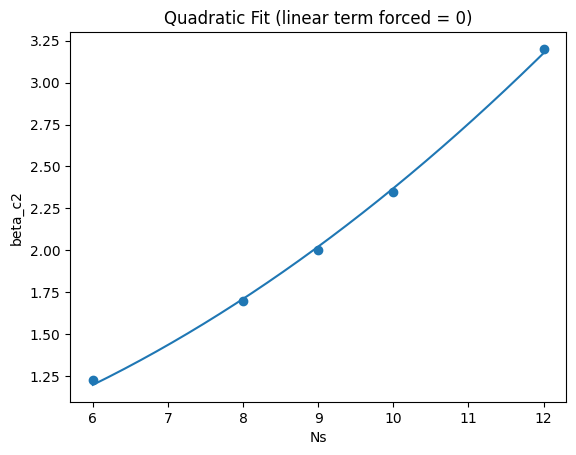

Coefficients [a, 0, c] = [0.01829372 0.         0.54103352]


In [49]:
import numpy as np
import matplotlib.pyplot as plt

beta_c2 = np.array([1.23, 1.8, 2.45, 3.17])
beta_c2 = np.array([1.23, 1.7, 2, 2.35, 3.2])
Ns = np.array([6, 8, 9, 10, 12])

mask = ~np.isnan(beta_c2)
Ns_fit = Ns[mask]
beta_fit = beta_c2[mask]

# ======== Modified part: fit only a*x^2 + c =========
# Build design matrix for model y = a*x^2 + c
X = np.column_stack([Ns_fit**2, np.ones_like(Ns_fit)])

# Solve for [a, c]
a, c = np.linalg.lstsq(X, beta_fit, rcond=None)[0]

# Make a poly1d-like object manually
coeffs = np.array([a, 0.0, c])   # linear term = 0 by force
poly = np.poly1d(coeffs)
# ======================================================

x = np.linspace(Ns_fit.min(), Ns_fit.max(), 200)
y = poly(x)

plt.figure()
plt.scatter(Ns_fit, beta_fit)
plt.plot(x, y)
plt.xlabel("Ns")
plt.ylabel("beta_c2")
plt.title("Quadratic Fit (linear term forced = 0)")
plt.show()

print("Coefficients [a, 0, c] =", coeffs)


In [50]:
heat_caps = np.load('ord_param_z8_fine_2_data_heat_cap_u.npy')
mus_list = np.load('ord_param_z8_fine_2_data.npy')
gammas_list = np.linspace(-1.4,2,150)
beta_list = np.linspace(0, 4, int(14*8))

FileNotFoundError: [Errno 2] No such file or directory: 'ord_param_z8_fine_2_data_heat_cap_u.npy'

In [ ]:
val = 1

d_heat = np.gradient(heat_caps[val], gammas_list)*(heat_caps[val])**4
print(beta_list[val])
plt.scatter(gammas_list, d_heat)
plt.axvline(x=0, color = "red")
plt.title(r"Heat Capacity vs $\gamma$ for $\mathbb{Z}$" + f"${N}$")
plt.xlim((-0.2, 0.2))